In [7]:
import pandas as pd
import numpy  as np
import pickle

from xgboost         import XGBClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt


In [8]:
# %load load_list_var.py
def load_vars(type):

    if type == "numerical":

        vars = []
        with open("Data/num_var.txt", "r") as f:
            for line in f:
                vars.append(str(line.strip()))

    elif type == "categorical":

        vars = []
        with open("Data/cat_var.txt", "r") as f:
            for line in f:
                vars.append(str(line.strip()))

    else:

        print("Not properly loaded var, type is {}".format(type))

    return vars


In [9]:
variables = [*load_vars('numerical'), *load_vars('categorical')]
variables.remove('CODE_GENDER')
variables.remove('EXT_SOURCE_1')
variables.remove('EXT_SOURCE_2')
variables.remove('EXT_SOURCE_3')

test_names = ['Output_preprocessing/Testing_set_woe_cat.csv.gz',
              'Output_xgboost_unrestricted/Testing_unrestricted_woe_6.csv.gz',
              'Output_xgboost_binning/Testing_with_woe_on_numerical_6.csv.gz',
              'Output_xgboost_ex_ante_binning/Testing_XGB_ex_woe_6.csv.gz']

names    = ['original',
            'unrestricted_6',
            'best_6',
            'ex_ante_6']

datasets = ['Output_preprocessing/Training_set_woe_cat.csv.gz',
            'Output_xgboost_unrestricted/Training_unrestricted_woe_6.csv.gz',
            'Output_xgboost_binning/Training_with_woe_on_numerical_6.csv.gz',
            'Output_xgboost_ex_ante_binning/Training_XGB_ex_woe_6.csv.gz']

In [5]:
for (name, dataset) in zip(names, datasets):
    
    training_data = pd.read_csv(dataset, compression='gzip')

    y = training_data['TARGET'].copy()
    X = training_data[variables].copy()

    filename     = 'Output_CV/{}.sav'.format(name)
    loaded_model = pickle.load(open(filename, 'rb'))
    
    params = loaded_model.get_params()
    
    xgb_classifier = XGBClassifier(**params)
    xgb_classifier.fit(X,y)
    
    pickle.dump(xgb_classifier, open('Output_final_models/{}.sav'.format(name), 'wb'))

[15:34:55] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:35:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:36:04] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

In [6]:
AUC = {}

num_obs = 1000

for (name, test_name) in zip(names, test_names):
    filename     = 'Output_final_models/{}.sav'.format(name)
    loaded_model = pickle.load(open(filename, 'rb'))
    
    data     = pd.read_csv(test_name, compression='gzip')
    
    aux_auc  = []
    n        = data.shape[0]
    
    for iteration in range(num_obs):
        
        df_aux = data.iloc[np.random.randint(n, size=n)]
        
        score  = roc_auc_score(df_aux['TARGET'], loaded_model.predict_proba(df_aux[variables])[:,1])
        aux_auc.append(score)
        
    AUC[name] = aux_auc
    
    print(np.mean(AUC[name]))

0.7266726818858668
0.7187759049404863
0.7145319021755453
0.710206031624922


In [7]:
for name in names:
    sort = sorted(AUC[name])
    print('95% conf interval for model {} is: [{}, {}] \n'.format(name, sort[50], sort[950]))

95% conf interval for model original is: [0.7205861295036566, 0.7328850318071028] 

95% conf interval for model unrestricted_6 is: [0.7124425966594545, 0.7250527682774902] 

95% conf interval for model best_6 is: [0.708269155762896, 0.7206439174765977] 

95% conf interval for model ex_ante_6 is: [0.7038411030644118, 0.7164456133560599] 



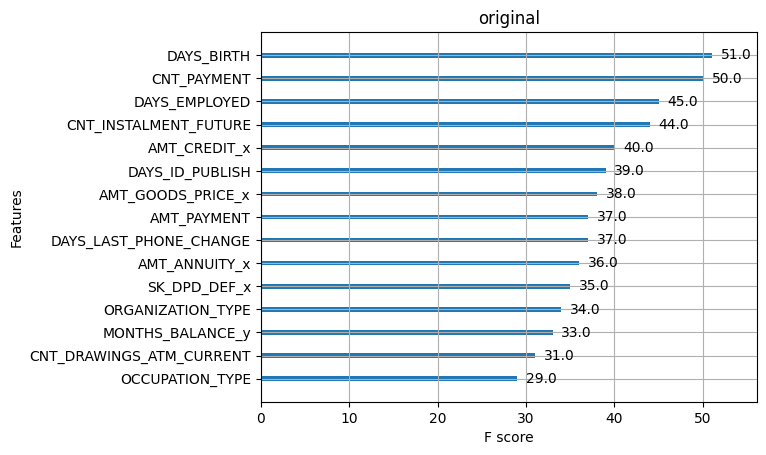

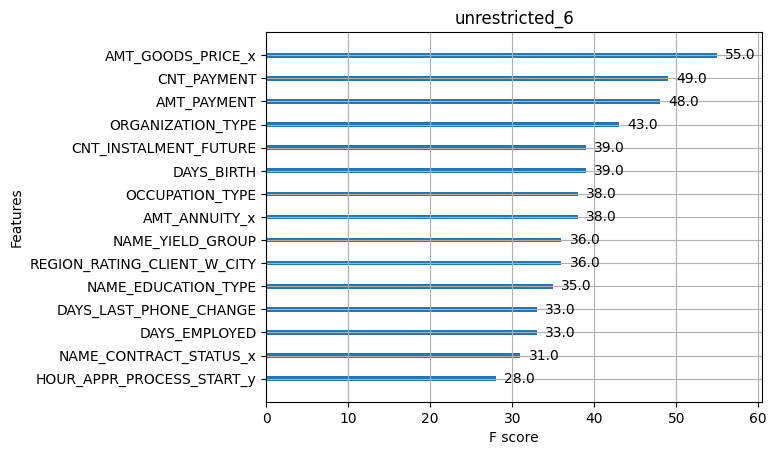

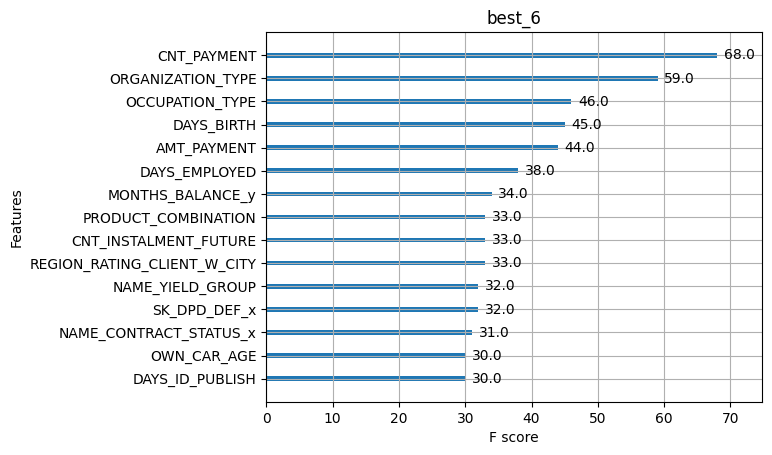

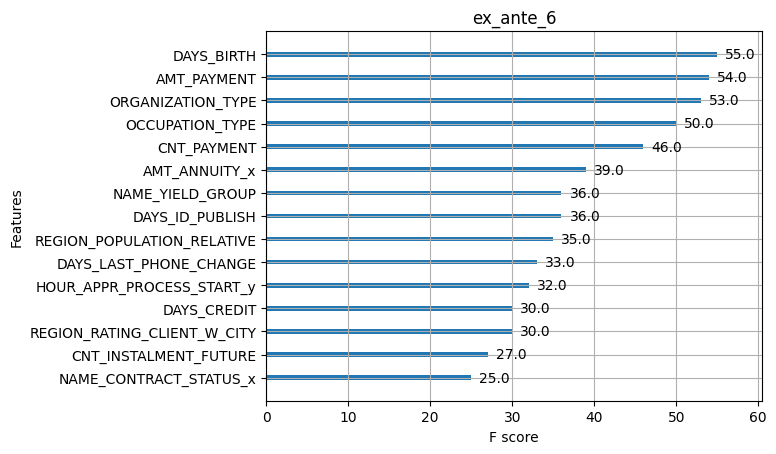

In [5]:
for name in names:
    filename = 'Output_final_models/{}.sav'.format(name)
    
    loaded_model = pickle.load(open(filename, 'rb'))
    
    xgb.plot_importance(loaded_model, max_num_features=15)
    plt.title('{}'.format(name))
plt.show()

In [8]:
dic_importances = {}

for name in names:
    filename = 'Output_final_models/{}.sav'.format(name)
    
    loaded_model = pickle.load(open(filename, 'rb'))
    
    dic_importances_model = {}
    for idx,var in enumerate(variables):
        dic_importances_model[var] = loaded_model.feature_importances_[idx]
        dic_importances_model = {k: v for k, v in sorted(dic_importances_model.items(), key=lambda item: -item[1])}
    
    dic_importances[name] = dic_importances_model

In [10]:
desc = pd.read_csv('Data/HomeCredit_columns_description_6.csv')

In [20]:
eval(desc.Gini_test_monotonic[2])

SyntaxError: unexpected EOF while parsing (<string>, line 1)

In [17]:
desc.keys()

Index(['Table', 'Row', 'Description', 'Special', 'Ex_ante', 'imputation',
       'missing', 'agg', 'Gini_train_positive', 'Gini_test_positive',
       'Gini_train_negative', 'Gini_test_negative', 'Gini_train_monotonic',
       'Gini_test_monotonic', 'Gini_train_ex_ante', 'Gini_test_ex_ante',
       'Gini_train_unrestricted', 'Gini_test_unrestricted',
       'Feature_importance', 'Flag_Catego_Nume', 'Monotonicity Chosen',
       'Drop_variable', 'Reason', 'Ruben'],
      dtype='object')

In [30]:
dic_importances.keys()

dict_keys(['original', 'unrestricted_6', 'best_6', 'ex_ante_6'])

In [10]:
dic = dic_importances['best_6']
for var in variables:
    idx = desc[desc.Row == var].index
    desc.loc[idx,'Feature_importance'] = dic[var]

In [11]:
desc.to_csv('Data/HomeCredit_columns_description_6.csv',index=False)

In [53]:
desc.keys()

Index(['Table', 'Row', 'Description', 'Special', 'Ex_ante', 'imputation',
       'missing', 'agg', 'Gini_train_positive', 'Gini_test_positive',
       'Gini_train_negative', 'Gini_test_negative', 'Gini_train_monotonic',
       'Gini_test_monotonic', 'Gini_train_ex_ante', 'Gini_test_ex_ante',
       'Gini_train_unrestricted', 'Gini_test_unrestricted',
       'Feature_importance'],
      dtype='object')

In [282]:
variable = 'REG_REGION_NOT_WORK_REGION'

idx = desc[desc.Row == variable].index

desc.loc[idx,'Drop_variable'] = 'keep'

desc.loc[idx,'Reason'] = 'client permanent adress not matching work adress is good'

In [10]:
f = open("dict_categoricals_to_woe.txt", "r")
dic_cat = eval(f.read())
f.close()

In [281]:
{k: v for k, v in sorted(dic_cat['REG_REGION_NOT_WORK_REGION'].items(), key=lambda item: item[1])}

{0: -2.4382168390141334, 1: -2.3307933384703032}

In [12]:
count = 0
for variable in list(dic.keys()):
    idx = desc[desc.Row == variable].index
    if not pd.isna(desc.loc[idx,'Drop_variable'].values[0]):
        continue
    if variable in variable in load_vars('categorical'):
        continue
    
    gini_pos = desc.loc[idx,'Gini_train_positive'].values[0]
    gini_neg = desc.loc[idx,'Gini_train_negative'].values[0]
    if dic[variable] < 1e-4:
        break
    print(variable)
    print(desc.loc[idx,'Table'].values[0])
    if gini_pos > gini_neg:
        print('monotony: 1')
    else:
        print('monotony: -1')
    
    if variable in variable in load_vars('categorical'):
        print('Categorical variable')
    else:
        print('Numerical variable')
    print(dic[variable],'\n')
    print(desc.loc[idx,'Drop_variable'].values[0])
    print(desc.loc[idx,'Reason'].values[0], '\n')
    print(desc.loc[idx,'Ruben'].values[0], '\n')
    print(desc.loc[idx,'Description'].values[0], '\n', '='*50)
    count += 1

CNT_DRAWINGS_OTHER_CURRENT
credit_card_balance.csv
monotony: -1
Numerical variable
0.0008308633 

nan
nan 

nan 

Number of other drawings during this month on the previous credit 
LIVINGAPARTMENTS_MEDI
application_{train|test}.csv
monotony: -1
Numerical variable
0.00045806667 

nan
nan 

nan 

Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 


## First Sieve

In [11]:
var_sieve = []

for idx in range(desc.shape[0]):
    drop     = desc.loc[idx,'Drop_variable']
    var_name = desc.loc[idx,'Row']
    if (pd.isna(drop) or drop.lower() == 'keep') and var_name in variables:
        var_sieve.append(var_name)

In [14]:
for (name, dataset) in zip(names, datasets):
    
    training_data = pd.read_csv(dataset, compression='gzip')

    y = training_data['TARGET'].copy()
    X = training_data[var_sieve].copy()

    filename     = 'Output_CV/{}.sav'.format(name)
    loaded_model = pickle.load(open(filename, 'rb'))
    
    params = loaded_model.get_params()
    
    xgb_classifier = XGBClassifier(**params)
    xgb_classifier.fit(X,y)
    
    pickle.dump(xgb_classifier, open('Output_final_models/{}_1S.sav'.format(name), 'wb'))

[15:45:42] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:46:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:46:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

In [15]:
AUC = {}

num_obs = 1000

for (name, test_name) in zip(names, test_names):
    filename     = 'Output_final_models/{}_1S.sav'.format(name)
    loaded_model = pickle.load(open(filename, 'rb'))
    
    data     = pd.read_csv(test_name, compression='gzip')
    
    aux_auc  = []
    n        = data.shape[0]
    
    for iteration in range(num_obs):
        
        df_aux = data.iloc[np.random.randint(n, size=n)]
        
        score  = roc_auc_score(df_aux['TARGET'], loaded_model.predict_proba(df_aux[var_sieve])[:,1])
        aux_auc.append(score)
        
    AUC[name] = aux_auc
    
    print(np.mean(AUC[name]))

0.6985129034405076
0.6916187548642708
0.6905190549855602
0.6804505191006927


In [16]:
for name in names:
    sort = sorted(AUC[name])
    print('95% conf interval for model {} is: [{}, {}] \n'.format(name, sort[50], sort[950]))

95% conf interval for model original is: [0.6923034400953931, 0.7047179873537637] 

95% conf interval for model unrestricted_6 is: [0.6849493350490826, 0.6983209229524975] 

95% conf interval for model best_6 is: [0.6840924388751105, 0.6970249723492632] 

95% conf interval for model ex_ante_6 is: [0.6739505601832989, 0.6871592688458168] 



In [13]:
num_obs = 1000

competitors = ['unrestricted_6','best_6']
testing     = ['Output_xgboost_unrestricted/Testing_unrestricted_woe_6.csv.gz',
               'Output_xgboost_binning/Testing_with_woe_on_numerical_6.csv.gz']

model_1 = 'Output_final_models/{}_1S.sav'.format(competitors[0])
model_2 = 'Output_final_models/{}_1S.sav'.format(competitors[1])

model_1 = pickle.load(open(model_1, 'rb'))
model_2 = pickle.load(open(model_2, 'rb'))

data_1  = pd.read_csv(testing[0], compression='gzip')
data_2  = pd.read_csv(testing[1], compression='gzip')

n       = data_1.shape[0]
random_numbers = np.random.randint(n, size=n)

data_1 = data_1.iloc[random_numbers]
data_2 = data_2.iloc[random_numbers]

results = []

for iteration in range(num_obs):
    score_1  = roc_auc_score(data_1['TARGET'], model_1.predict_proba(data_1[var_sieve])[:,1])
    score_2  = roc_auc_score(data_2['TARGET'], model_2.predict_proba(data_2[var_sieve])[:,1])
    results.append(score_1 > score_2) # score_1 is for unrestricted
    
print(np.sum(results))

1000


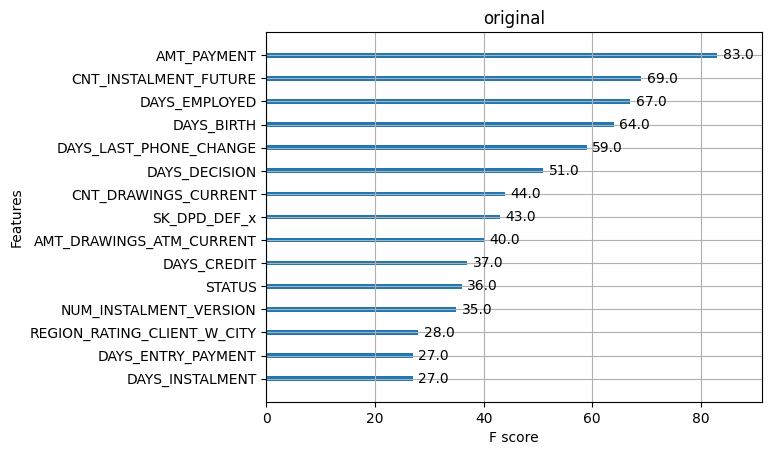

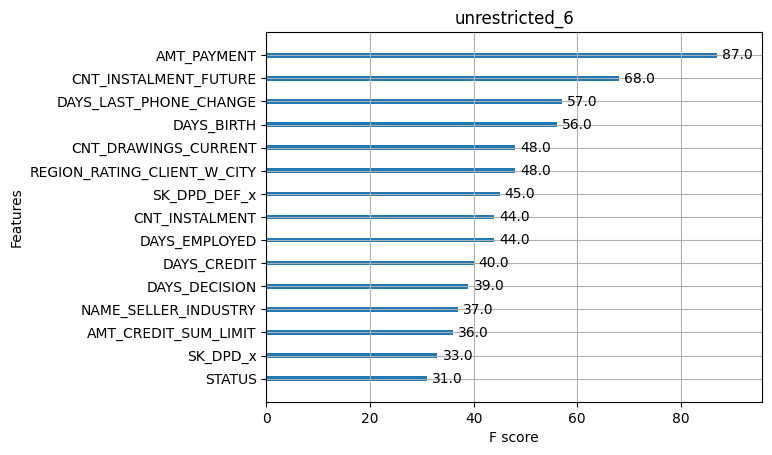

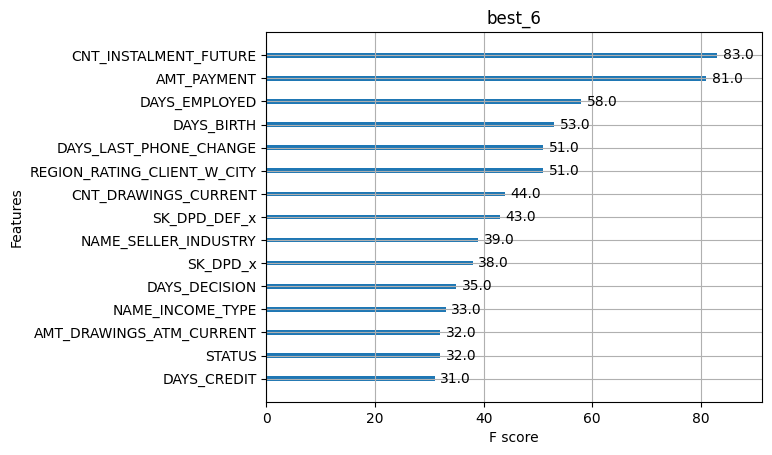

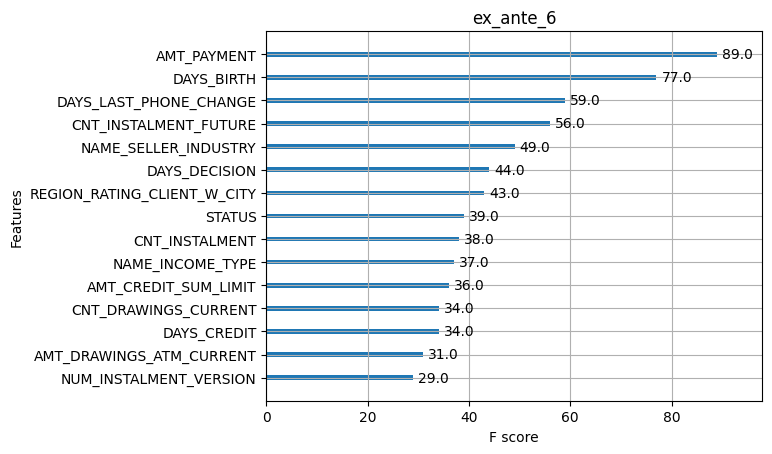

In [205]:
for name in names:
    filename = 'Output_final_models/{}_1S.sav'.format(name)
    
    loaded_model = pickle.load(open(filename, 'rb'))
    
    xgb.plot_importance(loaded_model, max_num_features=15)
    plt.title('{}'.format(name))
plt.show()

In [17]:
dic_importances = {}

for name in names:
    filename = 'Output_final_models/{}_1S.sav'.format(name)
    
    loaded_model = pickle.load(open(filename, 'rb'))
    
    dic_importances_model = {}
    for idx,var in enumerate(var_sieve):
        dic_importances_model[var] = loaded_model.feature_importances_[idx]
        dic_importances_model = {k: v for k, v in sorted(dic_importances_model.items(), key=lambda item: -item[1])}
    
    dic_importances[name] = dic_importances_model

In [18]:
dic = dic_importances['best_6']
for var in var_sieve:
    idx = desc[desc.Row == var].index
    desc.loc[idx,'Feature_importance_1S'] = dic[var]

In [291]:
variable = 'LANDAREA_AVG'

idx = desc[desc.Row == variable].index

desc.loc[idx,'Drop_variable'] = 'keep'

desc.loc[idx,'Reason'] = 'The monotony negative doesnt make much sense but it may be coz there re many missing '

In [10]:
f = open("dict_categoricals_to_woe.txt", "r")
dic_cat = eval(f.read())
f.close()

In [179]:
{k: v for k, v in sorted(dic_cat['FLAG_CONT_MOBILE'].items(), key=lambda item: item[1])}

{1: -2.4327401189768794, 0: -2.3025850929940455}

In [23]:
count = 0
for variable in list(var_sieve):
    idx = desc[desc.Row == variable].index
    if variable in variable in load_vars('numerical'):
        continue
    
    gini_pos = desc.loc[idx,'Gini_train_positive'].values[0]
    gini_neg = desc.loc[idx,'Gini_train_negative'].values[0]
    if dic[variable] < 1e-4:
        break
    print(variable)
    print(desc.loc[idx,'Table'].values[0])
    if gini_pos > gini_neg:
        print('monotony: 1')
    else:
        print('monotony: -1')
    
    if variable in variable in load_vars('categorical'):
        print('Categorical variable')
    else:
        print('Numerical variable')
    print(dic[variable],'\n')
    print(desc.loc[idx,'Drop_variable'].values[0])
    print(desc.loc[idx,'Reason'].values[0], '\n')
    print(desc.loc[idx,'Ruben'].values[0], '\n')
    print(desc.loc[idx,'Description'].values[0], '\n', '='*50)
    count += 1

FLAG_OWN_CAR
application_{train|test}.csv
monotony: -1
Categorical variable
0.012288668 

keep
owning a car is better than not owning one 

nan 

Flag if the client owns a car 
FLAG_OWN_REALTY
application_{train|test}.csv
monotony: -1
Categorical variable
0.0017156017 

keep
owning a house or a flat is good 

nan 

Flag if client owns a house or flat 
NAME_INCOME_TYPE
application_{train|test}.csv
monotony: -1
Categorical variable
0.021113005 

keep
Pensioners and state servants are less likely to default 

Revisar: parece que la tratas como numerca pero suena a categrica 

Clients income type (businessman, working, maternity leave,) 
NAME_HOUSING_TYPE
application_{train|test}.csv
monotony: -1
Categorical variable
0.011301264 

keep
having a more expensive house rises client assets hence less PD 

nan 

What is the housing situation of the client (renting, living with parents, ...) 


## Externals

In [20]:
variables = [*load_vars('numerical'), *load_vars('categorical')]
variables.remove('CODE_GENDER')


test_names = ['Output_preprocessing/Testing_set_woe_cat.csv.gz',
              'Output_xgboost_unrestricted/Testing_unrestricted_woe_6.csv.gz',
              'Output_xgboost_binning/Testing_with_woe_on_numerical_6.csv.gz',
              'Output_xgboost_ex_ante_binning/Testing_XGB_ex_woe_6.csv.gz']

names    = ['original',
            'unrestricted_6',
            'best_6',
            'ex_ante_6']

datasets = ['Output_preprocessing/Training_set_woe_cat.csv.gz',
            'Output_xgboost_unrestricted/Training_unrestricted_woe_6.csv.gz',
            'Output_xgboost_binning/Training_with_woe_on_numerical_6.csv.gz',
            'Output_xgboost_ex_ante_binning/Training_XGB_ex_woe_6.csv.gz']

In [21]:
for (name, dataset) in zip(names, datasets):
    
    training_data = pd.read_csv(dataset, compression='gzip')

    y = training_data['TARGET'].copy()
    X = training_data[variables].copy()

    filename     = 'Output_CV/{}.sav'.format(name)
    loaded_model = pickle.load(open(filename, 'rb'))
    
    params = loaded_model.get_params()
    
    xgb_classifier = XGBClassifier(**params)
    xgb_classifier.fit(X,y)
    
    pickle.dump(xgb_classifier, open('Output_final_models/{}_external.sav'.format(name), 'wb'))

[15:53:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:54:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:55:00] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

In [22]:
AUC = {}

num_obs = 1000

for (name, test_name) in zip(names, test_names):
    filename     = 'Output_final_models/{}_external.sav'.format(name)
    loaded_model = pickle.load(open(filename, 'rb'))
    
    data     = pd.read_csv(test_name, compression='gzip')
    
    aux_auc  = []
    n        = data.shape[0]
    
    for iteration in range(num_obs):
        
        df_aux = data.iloc[np.random.randint(n, size=n)]
        
        score  = roc_auc_score(df_aux['TARGET'], loaded_model.predict_proba(df_aux[variables])[:,1])
        aux_auc.append(score)
        
    AUC[name] = aux_auc
    
    print(np.mean(AUC[name]))

0.7693319332015865
0.7639082801155987
0.7598776240961074
0.7573666893047019


In [192]:
desc.loc[3,'Row']

'CODE_GENDER'